# Абстрактно

Будем анализировать цену ноутбуков. За основу возьмем датасет из Kaggle https://www.kaggle.com/datasets/muhammetvarl/laptop-price?datasetId=957775&language=Python, где все уже красиво собрано за нас. Там же наши коллеги из сферы эконометрического анализа и DS опубликовали множество решений задач, в зависимости от их видения и постановки. Поэтому я буду периодически пользоваться их идеями и инсайтами, оставляя ссылки на источники

# 1 Загрузка и первичная обработка исходных данных

In [1]:
import pandas as pd
import numpy as np

### 1.1 Загрузим данные и посмотрим на нашу прекрасную таблицу

Она маленькая, поэтому хороший вариант - просто скачать csv и прочитать его

In [2]:
df = pd.read_csv('laptop_price.csv')
df

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,1499.00
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.00


Вообще не думая сразу делаем 2 вещи - убираем колонку с id ноутбука, а также переводим вес ноутбука и оперативку в тип float. Для этого нужно убрать 2 последние буквы в этих признаках

In [3]:
df = df.drop('laptop_ID', axis=1)
df['Weight'] = df['Weight'].apply(lambda x: float(x[:-2]))
df['Ram'] = df['Ram'].apply(lambda x: float(x[:-2]))
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8.0,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16.0,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8.0,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


### 1.2 Теперь приступим к более умной обработке признаков (такое даже не стыдно назвать feature engineering)

Хочется привести признак памяти к такому же виду, как оперативку и вес. При этом тут уже сложнее - она бывает в гигабайтах, бывает в терабайтах, есть множество ненужных слов, и так далее. Один из грандмастеров Kaggle, он же старший Data Scientist, обработал этот признак достаточно костыльным способом - по сути перебрал всевозможные условия. Поэтому, недолго думая, просто скопируем его код, а затем переведем это в тип float

In [4]:
# https://www.kaggle.com/code/michau96/what-determines-price-of-a-laptop

df['Memory'] = df['Memory'].replace(['128GB SSD', '128GB Flash Storage', '128GB HDD'], '128')
df['Memory'] = df['Memory'].replace(['256GB SSD', '256GB Flash Storage'], '256')
df['Memory'] = df['Memory'].replace(['512GB SSD', '256GB SSD +  256GB SSD', '512GB Flash Storage'], '512')
df['Memory'] = df['Memory'].replace(['500GB HDD'], '500')
df['Memory'] = df['Memory'].replace(['1TB HDD', '1TB SSD', '1.0TB Hybrid', '512GB SSD +  512GB SSD', '1.0TB HDD'], '1024')
df['Memory'] = df['Memory'].replace(['2TB HDD', '1TB SSD +  1TB HDD', '1TB HDD +  1TB HDD',], '2048')
df['Memory'] = df['Memory'].replace(['128GB SSD +  2TB HDD'], '2160')
df['Memory'] = df['Memory'].replace(['32GB Flash Storage', '32GB SSD', '32GB HDD'], '32')
df['Memory'] = df['Memory'].replace(['256GB SSD +  500GB HDD'], '756')
df['Memory'] = df['Memory'].replace(['16GB Flash Storage', '16GB SSD'], '16')
df['Memory'] = df['Memory'].replace(['128GB SSD +  1TB HDD'], '1148')
df['Memory'] = df['Memory'].replace(['64GB Flash Storage', '64GB SSD'], '64')
df['Memory'] = df['Memory'].replace(['180GB SSD'], '180')
df['Memory'] = df['Memory'].replace(['240GB SSD'], '240')
df['Memory'] = df['Memory'].replace(['512GB SSD +  256GB SSD'], '768')
df['Memory'] = df['Memory'].replace(['256GB SSD +  1TB HDD', '256GB SSD +  1.0TB Hybrid'], '1280')
df['Memory'] = df['Memory'].replace(['512GB SSD +  1TB HDD', '512GB SSD +  1.0TB Hybrid'], '1536')
df['Memory'] = df['Memory'].replace(['256GB SSD +  2TB HDD'], '2304')
df['Memory'] = df['Memory'].replace(['128GB SSD +  2TB HDD'], '2176')
df['Memory'] = df['Memory'].replace(['512GB SSD +  2TB HDD'], '2560')
df['Memory'] = df['Memory'].replace(['8GB SSD'], '8')
df['Memory'] = df['Memory'].replace(['508GB Hybrid'], '508')
df['Memory'] = df['Memory'].replace(['64GB Flash Storage +  1TB HDD'], '1088')
df['Memory'] = df['Memory'].astype(float)
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8.0,128.0,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,128.0,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,256.0,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16.0,512.0,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8.0,256.0,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


In [5]:
df.dtypes

Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                 float64
Memory              float64
Gpu                  object
OpSys                object
Weight              float64
Price_euros         float64
dtype: object

У меня очень много вопросов к признаку Product. Во-первых, он сильно коррелирует с признаком бренда (вряд ли мы найдем Macbook Air у Леново и Yoga 900-13ISK у Apple). Во-вторых, мы хотим генерализованную модель, и, если мы хотим "Предложите свой товар для рынка с определенным набором характеристик и спрогнозируйте его цену с помощью Вашей модели", то вряд ли мы будем прописывать его название. Наконец, есть предположение, что существует множество уникальных товаров в датасете. Давайте проверим, сколько таких

In [6]:
df2 = df.groupby(['Company', 'Product']).agg(['count']).reset_index().iloc[:, :3]
df2.columns = ['Company', 'Product', 'count']
df2.loc[df2['count'] == 1]

,Company,Product,count
0,Acer,A715-71G-59DH (i5-7300HQ/8GB/1TB/GeForce,1
1,Acer,Aspire 1,1
8,Acer,Aspire A515-51G-32MX,1
9,Acer,Aspire A515-51G-37JS,1
10,Acer,Aspire A515-51G-59QF,1
...,...,...,...
614,Toshiba,Tecra Z50-D-10E,1
615,Vero,K146 (N3350/4GB/32GB/W10),1
616,Vero,K147 (N3350/4GB/32GB/FHD/W10),1
617,Vero,V131 (X5-Z8350/4GB/32GB/FHD/W10),1


Более, чем треть датасета состоит из уникальных товаров. Думаю, этот признак можно смело убирать

In [7]:
df = df.drop('Product', axis=1)

Посмотрим на другие категориальные признаки

In [8]:
df['TypeName'].value_counts() # тут мне все нравится

Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation            29
Netbook                25
Name: TypeName, dtype: int64

In [9]:
df['ScreenResolution'].value_counts()

Full HD 1920x1080                                507
1366x768                                         281
IPS Panel Full HD 1920x1080                      230
IPS Panel Full HD / Touchscreen 1920x1080         53
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
Touchscreen 2560x1440                              7
IPS Panel 1366x768                                 7
4K Ultra HD 3840x2160                              7
IPS Panel Retina Display 2560x1600                 6
Touchscreen 2256x1504                              6
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
IPS Panel Retina Display 2304x1440                 6
IPS Panel Touchscreen 2560x1440               

В случае с разрешением экрана, все не так плохо, как с признаком имя товара, но я бы не хотел в таком виде его вставлять в OHE, нужен дополнительный анализ

Снова обратимся за помощью к https://www.kaggle.com/code/michau96/what-determines-price-of-a-laptop

Грандмастер написал хорошую функцию, которая строит ящики с усами, а также привел признак разрешения экрана к нормальному виду (что в принципе делается легко, но все же уже сделано за нас :) )

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
    
}

plt.rcParams["figure.figsize"] = (18, 11.5)
plt.style.use('bmh')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'#f0f0f0'})
    
def plot_box(x, y, xlabel, ylabel, title, subtitle, color, title_position, subtitle_position, order=None):
    ax = sns.boxplot(data = df, y = y, x = x, order = order,
                 linewidth = 1.2, color = color, **PROPS,
                 flierprops = dict(marker = 'o', markeredgecolor = 'black', markersize = 6.5, linestyle = 'none', markerfacecolor = color, alpha = 0.9))

    plt.xlabel(xlabel, fontweight = 'bold', fontsize = 16)
    plt.ylabel(ylabel, fontweight = 'bold', fontsize = 16)
    ax.tick_params(labelsize = 14)
    ax.text(x = title_position, y = 1.07, s = title, fontsize = 22.5, weight = 'bold', ha = 'center', va = 'bottom', transform = ax.transAxes)
    ax.text(x = subtitle_position, y = 1.03, s = subtitle, fontsize = 16.5, alpha = 0.75, ha = 'center', va = 'bottom', transform = ax.transAxes)
    plt.show()

In [11]:
df["ScreenResolution"] = df["ScreenResolution"].astype('string')
df["ScreenResolution"] = df["ScreenResolution"].str.replace('4K', '', regex=True)
df["ScreenResolution"] = df["ScreenResolution"].str.replace('\D', '', regex=True)

def insert_dash(string, index):
    return string[:index] + 'x' + string[index:]

i = 0

for i in range(0,len(df["ScreenResolution"])):
    df["ScreenResolution"][i] = insert_dash(df["ScreenResolution"][i],4)
    i = i + 1
    
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,Ultrabook,13.3,2560x1600,Intel Core i5 2.3GHz,8.0,128.0,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,128.0,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,Notebook,15.6,1920x1080,Intel Core i5 7200U 2.5GHz,8.0,256.0,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,Ultrabook,15.4,2880x1800,Intel Core i7 2.7GHz,16.0,512.0,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,Ultrabook,13.3,2560x1600,Intel Core i5 3.1GHz,8.0,256.0,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


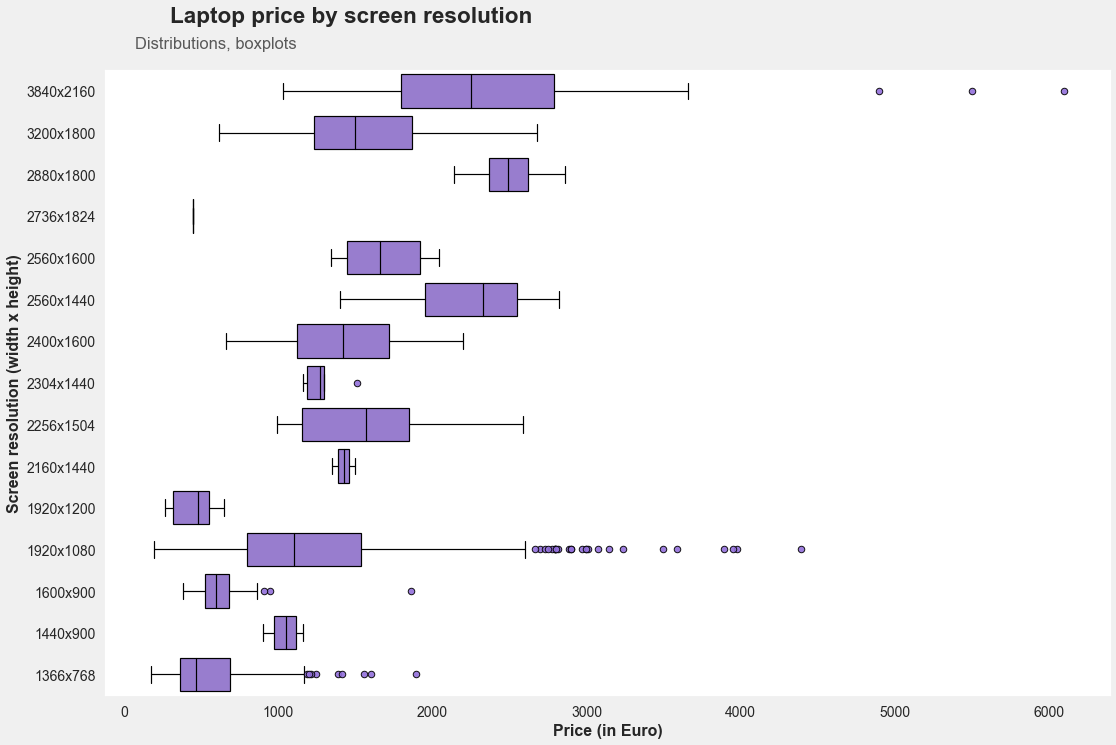

In [12]:
plot_box(x = "Price_euros", y = "ScreenResolution", xlabel = 'Price (in Euro)', ylabel = "Screen resolution (width x height)", title = "Laptop price by screen resolution",
         subtitle = "Distributions, boxplots", color = "mediumpurple", title_position = 0.245, subtitle_position = 0.11,
         order = ["3840x2160", "3200x1800", "2880x1800", "2736x1824", "2560x1600", "2560x1440", "2400x1600", "2304x1440", "2256x1504", "2160x1440", 
                  "1920x1200", "1920x1080","1600x900", "1440x900", "1366x768"])

In [13]:
df['ScreenResolution'].value_counts()

1920x1080    841
1366x768     308
3840x2160     43
3200x1800     27
2560x1440     23
1600x900      23
2304x1440      6
2560x1600      6
2256x1504      6
1920x1200      5
1440x900       4
2880x1800      4
2400x1600      4
2160x1440      2
2736x1824      1
Name: ScreenResolution, dtype: Int64

Кажется, что признак важный, тем более у нас уже не так все плохо с уникальными значениями после нашего кодирования. Видно, что, в среднем, чем лучше разрешение экрана, тем дороже ноутбук. При этом я больше привык анализировать табличные значения, поэтому сделаем агрегированные признаки в разрезе разрешения экрана, а затем отсортируем по убыванию среднего значения цены

In [14]:
df.groupby('ScreenResolution')['Price_euros'].agg(['mean', 'median', 'min', 'max']).reset_index().sort_values('mean', ascending=False)

,ScreenResolution,mean,median,min,max
12,2880x1800,2493.847500,2488.710,2139.97,2858.00
14,3840x2160,2424.764186,2250.680,1029.00,6099.00
9,2560x1440,2244.383043,2330.000,1399.00,2824.00
10,2560x1600,1679.956667,1661.075,1339.69,2040.00
6,2256x1504,1612.308333,1569.500,989.00,2589.00
13,3200x1800,1578.855556,1499.000,615.00,2680.00
5,2160x1440,1424.000000,1424.000,1349.00,1499.00
8,2400x1600,1423.000000,1417.000,659.00,2199.00
7,2304x1440,1279.900000,1270.700,1163.00,1510.00
3,1920x1080,1223.607325,1099.000,196.00,4389.00


В принципе, да. Видно, что цифры, которые стоят повыше, обычно имеют более высокие показатели цены, чем цифры, которые пониже. При этом разрешение 2736x1824 кажется каким-то выбросом (особенно видно по графику). Хоть у нас и мало данных, их не настолько мало, чтобы я не мог себе позволить выкинуть одно наблюдение. Также я думаю будет невредно преобразовать это в числовой признак (тем более их так любит LinReg). Можно сделать даже 3: ширина, высота, широна, умноженная на высоту. В таком случае все эти признаки будут линейно независимыми, поэтому с сильной мультиколлинеарностью не столкнемся (но мы это протестируем)

In [15]:
df = df.loc[~(df['ScreenResolution'] == '2736x1824')]
df[['ScreenResolution_width', 'ScreenResolution_height']] = df['ScreenResolution'].str.split('x', expand=True)
df['ScreenResolution_width'] = df['ScreenResolution_width'].astype(float)
df['ScreenResolution_height'] = df['ScreenResolution_height'].astype(float)
df['ScreenResolution_multiplication'] = df['ScreenResolution_width'] * df['ScreenResolution_height']
df = df.drop('ScreenResolution', axis=1)
df.index = np.arange(0, len(df))
df.head()

,Company,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenResolution_width,ScreenResolution_height,ScreenResolution_multiplication
0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8.0,128.0,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2560.0,1600.0,4096000.0
1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8.0,128.0,Intel HD Graphics 6000,macOS,1.34,898.94,1440.0,900.0,1296000.0
2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8.0,256.0,Intel HD Graphics 620,No OS,1.86,575.00,1920.0,1080.0,2073600.0
3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16.0,512.0,AMD Radeon Pro 455,macOS,1.83,2537.45,2880.0,1800.0,5184000.0
4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8.0,256.0,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,2560.0,1600.0,4096000.0


Остается разобраться с признаками процессоров. Предлагаю начать с того, что я сделаю агрегацию по значениям ключа признака, а затем посмотрю, какое распределение имеет частота присутствия атрибута в датасете

In [16]:
df3 = df.groupby('Cpu').agg('count').reset_index().iloc[:, : 2]
df3.columns = ['Cpu', 'count']
df3.describe([.1, .25, .5, .75, .9])

,count
count,118.000000
mean,11.033898
std,27.905804
min,1.000000
10%,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
90%,28.600000
max,190.000000


In [17]:
df4 = df.groupby('Gpu').agg('count').reset_index().iloc[:, : 2]
df4.columns = ['Gpu', 'count']
df4.describe([.1, .25, .5, .75, .9])

,count
count,110.000000
mean,11.836364
std,33.414420
min,1.000000
10%,1.000000
25%,1.000000
50%,3.000000
75%,7.750000
90%,28.100000
max,281.000000


Как обычно, множество значений, которые встречаются один раз. Предлагаю посмотреть, что это за значения

In [18]:
df3.loc[df3['count'] == 1]

,Cpu,count
3,AMD A12-Series 9700P 2.5GHz,1
6,AMD A4-Series 7210 2.2GHz,1
7,AMD A6-Series 7310 2GHz,1
9,AMD A6-Series 9220 2.9GHz,1
13,AMD A9-Series 9420 2.9GHz,1
16,AMD E-Series 6110 1.5GHz,1
18,AMD E-Series 9000 2.2GHz,1
19,AMD E-Series 9000e 1.5GHz,1
20,AMD E-Series E2-6110 1.5GHz,1
21,AMD E-Series E2-9000 2.2GHz,1


В общем, одно и то же называют разными словами. Я не очень большой специалист по процессорам, поэтому предлагаю довериться грандмастеру с Kaggle и обработать эти признаки так, как делает он (https://www.kaggle.com/code/michau96/what-determines-price-of-a-laptop)

In [19]:
df['Cpu'] = df['Cpu'].replace(['Intel Core i7 7700HQ 2.8GHz', 'Intel Core i7 7500U 2.7GHz', 'Intel Core i7 8550U 1.8GHz', 'Intel Core i7 6920HQ 2.9GHz',
                              'Intel Core i7 2.7GHz', 'Intel Core i7 6500U 2.5GHz', 'Intel Core i7 6700HQ 2.6GHz', 'Intel Core i7 6560U 2.2GHz',
                              'Intel Core i7 2.9GHz', 'Intel Core i7 6600U 2.6GHz', 'Intel Core i7 7600U 2.8GHz', 'Intel Core i7 6820HK 2.7GHz',
                              'Intel Core i7 7820HK 2.9GHz', 'Intel Core i7 6820HQ 2.7GHz', 'Intel Core i7 7Y75 1.3GHz', 'Intel Core i7 7820HQ 2.9GHz',
                              'Intel Core i7 7660U 2.5GHz', 'Intel Core i7 6500U 2.50GHz', 'Intel Core i7 7500U 2.5GHz', 'Intel Core i7 2.2GHz', 'Intel Core i7 2.8GHz',
                              'Intel Core i7 7560U 2.4GHz', 'Intel Core i7 8650U 1.9GHz', 'Intel Core i7 7700HQ 2.7GHz'], 'Intel Core i7')
df['Cpu'] = df['Cpu'].replace(['Intel Core i5 7200U 2.5GHz', 'Intel Core i5 8250U 1.6GHz', 'Intel Core i5 7200U 2.50GHz', 'Intel Core i5 2.9GHz', 'Intel Core i5 7300U 2.6GHz',
                              'Intel Core i5 6440HQ 2.6GHz', 'Intel Core i5 6200U 2.3GHz', 'Intel Core i5 7300HQ 2.5GHz', 'Intel Core i5 2.0GHz', 'Intel Core i5 6300U 2.4GHz',
                              'Intel Core i5 6300HQ 2.3GHz', 'Intel Core i5 7440HQ 2.8GHz', 'Intel Core i5 7Y54 1.2GHz', 'Intel Core i5 1.6GHz', 'Intel Core i5 1.8GHz',
                              'Intel Core i5 3.1GHz', 'Intel Core i5 1.3GHz', 'Intel Core i5 7200U 2.7GHz', 'Intel Core i5 2.3GHz', 'Intel Core i5 7Y57 1.2GHz',
                              'Intel Core i5 6260U 1.8GHz', 'Intel Core i5 7500U 2.7GHz', 'Intel Core i5 7200U 2.70GHz'], 'Intel Core i5')
df['Cpu'] = df['Cpu'].replace(['Intel Core i3 6006U 2GHz', 'Intel Core i3 7100U 2.4GHz', 'Intel Core i3 6006U 2.0GHz', 'Intel Core i3 6100U 2.3GHz', 'Intel Core i3 7130U 2.7GHz',
                              'Intel Core i3 6100U 2.1GHz', 'Intel Core i3 6006U 2.2GHz'], 'Intel Core i3')
df['Cpu'] = df['Cpu'].replace(['Intel Pentium Dual Core 4405U 2.1GHz', 'Intel Core M m3-7Y30 2.2GHz', 'Intel Core M 7Y30 1.0GHz', 'Intel Core M 6Y54 1.1GHz',
                              'Intel Pentium Dual Core N4200 1.1GHz', 'Intel Celeron Quad Core N3710 1.6GHz', 'Intel Core M M3-6Y30 0.9GHz', 'Intel Celeron Dual Core N3350 1.1GHz',
                              'Intel Atom Z8350 1.92GHz', 'Intel Celeron Dual Core N3350 1.1GHz', 'Intel Celeron Dual Core N3060 1.6GHz', 'Intel Pentium Quad Core N4200 1.1GHz',
                              'Intel Pentium Quad Core N3710 1.6GHz', 'Intel Celeron Dual Core N3050 1.6GHz', 'Intel Celeron Quad Core N3450 1.1GHz',
                              'Intel Atom x5-Z8350 1.44GHz', 'Intel Core M 6Y75 1.2GHz', 'Intel Celeron Dual Core 3205U 1.5GHz', 'Intel Atom x5-Z8550 1.44GHz',
                              'Intel Celeron Dual Core 3855U 1.6GHz', 'Intel Core M 6Y30 0.9GHz', 'Intel Xeon E3-1505M V6 3GHz', 'Intel Core M 1.2GHz',
                              'Intel Pentium Quad Core N3700 1.6GHz', 'Intel Celeron Dual Core N3060 1.60GHz', 'Intel Core M m7-6Y75 1.2GHz', 'Intel Celeron Dual Core N3350 2.0GHz',
                              'Intel Atom x5-Z8300 1.44GHz', 'Intel Core M m3 1.2GHz', 'Intel Xeon E3-1535M v5 2.9GHz', 'Intel Celeron Dual Core N3350 2GHz',
                              'Intel Atom X5-Z8350 1.44GHz', 'Intel Core M M7-6Y75 1.2GHz', 'Intel Xeon E3-1535M v6 3.1GHz', 'Intel Pentium Dual Core 4405Y 1.5GHz',
                              'Intel Core M 1.1GHz', 'Intel Celeron Quad Core N3160 1.6GHz'], 'Intel Other')
df['Cpu'] = df['Cpu'].replace(['AMD E-Series 9000e 1.5GHz', 'AMD E-Series E2-6110 1.5GHz', 'AMD E-Series 9000 2.2GHz', 'AMD Ryzen 1600 3.2GHz', 'AMD A9-Series 9420 3GHz',
                              'AMD A6-Series 9220 2.5GHz', 'AMD A12-Series 9720P 3.6GHz', 'AMD A8-Series 7410 2.2GHz', 'AMD A9-Series 9410 2.9GHz', 'AMD Ryzen 1700 3GHz',
                              'AMD A12-Series 9700P 2.5GHz', 'AMD A4-Series 7210 2.2GHz', 'AMD FX 9830P 3GHz', 'AMD E-Series E2-9000 2.2GHz', 'AMD A6-Series 7310 2GHz',
                              'AMD E-Series 6110 1.5GHz', 'AMD A9-Series A9-9420 3GHz', 'AMD A12-Series 9720P 2.7GHz', 'AMD E-Series 7110 1.8GHz', 'AMD FX 8800P 2.1GHz',
                              'AMD A6-Series 9220 2.9GHz', 'AMD A9-Series 9420 2.9GHz', 'AMD A10-Series 9600P 2.4GHz', 'AMD E-Series E2-9000e 1.5GHz', 'AMD A10-Series A10-9620P 2.5GHz',
                              'AMD A6-Series A6-9220 2.5GHz', 'AMD A10-Series 9620P 2.5GHz'], 'AMD')
df['Cpu'] = df['Cpu'].replace(['Samsung Cortex A72&A53 2.0GHz'], 'Other')

In [20]:
df['Gpu'] = df['Gpu'].replace(['Nvidia GeForce GTX 1050', 'Nvidia GeForce GTX 1060', 'Nvidia GeForce 940MX', 'Nvidia GeForce GTX 1070', 'Nvidia GeForce GTX 1050 Ti',
                               'Nvidia GeForce 930MX', 'Nvidia GeForce MX150', 'Nvidia GeForce GTX 960M', 'Nvidia GeForce 920MX', 'Nvidia GeForce GTX 980M', 'Nvidia GeForce GTX 950M',
                               'Nvidia GeForce 930M', 'Nvidia GeForce 920M', 'Nvidia GeForce MX130', 'Nvidia GeForce GTX 1080', 'Nvidia GeForce 920MX', 'Nvidia GeForce 930MX',
                               'Nvidia GeForce GTX 970M', 'Nvidia GeForce GT 940MX', 'Nvidia GeForce GTX 965M', 'Nvidia GeForce 920MX', 'Nvidia GeForce 930MX', 'Nvidia GeForce GTX 940MX',
                               'Nvidia GeForce GTX 1050M', 'Nvidia GeForce 150MX', 'Nvidia GeForce GTX 1050Ti', 'Nvidia GeForce GTX 960', 'Nvidia GeForce GTX 960<U+039C>',
                               'Nvidia GeForce GTX1050 Ti', 'Nvidia GeForce GTX1080', 'Nvidia GeForce 920', 'Nvidia GeForce GTX 980', 'Nvidia GeForce 930MX', 'Nvidia GeForce 960M',
                               'Nvidia GeForce 920MX', 'Nvidia GeForce 940M', 'Nvidia GeForce GTX 980', 'Nvidia GeForce GTX 1070M', 'Nvidia GeForce GTX 930MX', 'Nvidia GeForce GTX1060',
                               'Nvidia GeForce GTX 940M', 'Nvidia GeForce 930MX ', 'Nvidia GeForce 920MX', 'Nvidia GeForce GTX 980',  'Nvidia GeForce 920MX ', 'Nvidia GeForce GTX 980 '], 'Nvidia GeForce')
df['Gpu'] = df['Gpu'].replace(['Nvidia Quadro M1200', 'Nvidia Quadro M620', 'Nvidia Quadro M1000M', 'Nvidia Quadro M2200M', 'Nvidia Quadro M2200', 'Nvidia Quadro M520M', 
                               'Nvidia Quadro M2000M', 'Nvidia Quadro M3000M', 'Nvidia Quadro M620M', 'Nvidia GTX 980 SLI', 'Nvidia Quadro 3000M', 'Nvidia Quadro M500M'], 'Nvidia Quadro/GTX')
df['Gpu'] = df['Gpu'].replace(['Intel HD Graphics 620', 'Intel HD Graphics 520', 'Intel UHD Graphics 620', 'Intel HD Graphics 500', 'Intel HD Graphics 400', 'Intel Iris Graphics 540',
                               'Intel HD Graphics', 'Intel HD Graphics 515', 'Intel HD Graphics 615', 'Intel HD Graphics 505', 'Intel HD Graphics 405', 'Intel Iris Plus Graphics 640',
                               'Intel HD Graphics 6000', 'Intel HD Graphics 510', 'Intel HD Graphics 630', 'Intel HD Graphics 5300', 'Intel Iris Plus Graphics 650', 'Intel HD Graphics 620',
                               'Intel Iris Graphics 550', 'Intel Iris Pro Graphics', 'Intel Graphics 620', 'Intel HD Graphics 620', 'Intel HD Graphics 540', 'Intel HD Graphics 530', 
                               'Intel HD Graphics 620', 'Intel HD Graphics 620 '], 'Intel Graphics')
df['Gpu'] = df['Gpu'].replace(['AMD Radeon 530', 'AMD Radeon R5 M430', 'AMD Radeon 520', 'AMD Radeon R7 M445', 'AMD Radeon R5', 'AMD Radeon R5 M420', 'AMD Radeon R5 M330',
                               'AMD Radeon R2', 'AMD Radeon R4 Graphics', 'AMD Radeon RX 580', 'AMD Radeon R7 M440', 'AMD Radeon RX 550', 'AMD Radeon R2 Graphics', 'AMD Radeon R5 M420X',
                               'AMD Radeon R4', 'AMD Radeon RX 540', 'AMD Radeon R7 M460', 'AMD FirePro W4190M', 'AMD Radeon R7 M360', 'AMD Radeon 540', 'AMD FirePro W4190M',
                               'AMD Radeon R7 Graphics', 'AMD Radeon Pro 560', 'AMD Radeon R7', 'AMD Radeon RX 560', 'AMD Radeon Pro 455', 'AMD FirePro W6150M', 'AMD Radeon R3',
                               'AMD R4 Graphics', 'AMD Radeon Pro 555', 'AMD Radeon R5 430', 'AMD Radeon R7 M465', 'AMD R17M-M1-70', 'AMD Radeon R5 M315', 'AMD Radeon R7 M365X',
                               'AMD Radeon R9 M385', 'AMD FirePro W5130M', 'AMD Radeon R5 520', 'AMD FirePro W4190M '], 'AMD')
df['Gpu'] = df['Gpu'].replace(['ARM Mali T860 MP4'], 'ARM')

In [21]:
print(df.shape)
df.head()

(1302, 13)


,Company,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenResolution_width,ScreenResolution_height,ScreenResolution_multiplication
0,Apple,Ultrabook,13.3,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.37,1339.69,2560.0,1600.0,4096000.0
1,Apple,Ultrabook,13.3,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.34,898.94,1440.0,900.0,1296000.0
2,HP,Notebook,15.6,Intel Core i5,8.0,256.0,Intel Graphics,No OS,1.86,575.00,1920.0,1080.0,2073600.0
3,Apple,Ultrabook,15.4,Intel Core i7,16.0,512.0,AMD,macOS,1.83,2537.45,2880.0,1800.0,5184000.0
4,Apple,Ultrabook,13.3,Intel Core i5,8.0,256.0,Intel Graphics,macOS,1.37,1803.60,2560.0,1600.0,4096000.0


##### Вот теперь я наконец-то доволен тем, как выглядит наш датасет

# 2 Анализ признаков и таргета

In [22]:
df.head()

,Company,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenResolution_width,ScreenResolution_height,ScreenResolution_multiplication
0,Apple,Ultrabook,13.3,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.37,1339.69,2560.0,1600.0,4096000.0
1,Apple,Ultrabook,13.3,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.34,898.94,1440.0,900.0,1296000.0
2,HP,Notebook,15.6,Intel Core i5,8.0,256.0,Intel Graphics,No OS,1.86,575.00,1920.0,1080.0,2073600.0
3,Apple,Ultrabook,15.4,Intel Core i7,16.0,512.0,AMD,macOS,1.83,2537.45,2880.0,1800.0,5184000.0
4,Apple,Ultrabook,13.3,Intel Core i5,8.0,256.0,Intel Graphics,macOS,1.37,1803.60,2560.0,1600.0,4096000.0


### 2.1 Сразу посмотрим, какие признаки коррелируют с таргетом, и нет ли у нас мультиколлинеарности

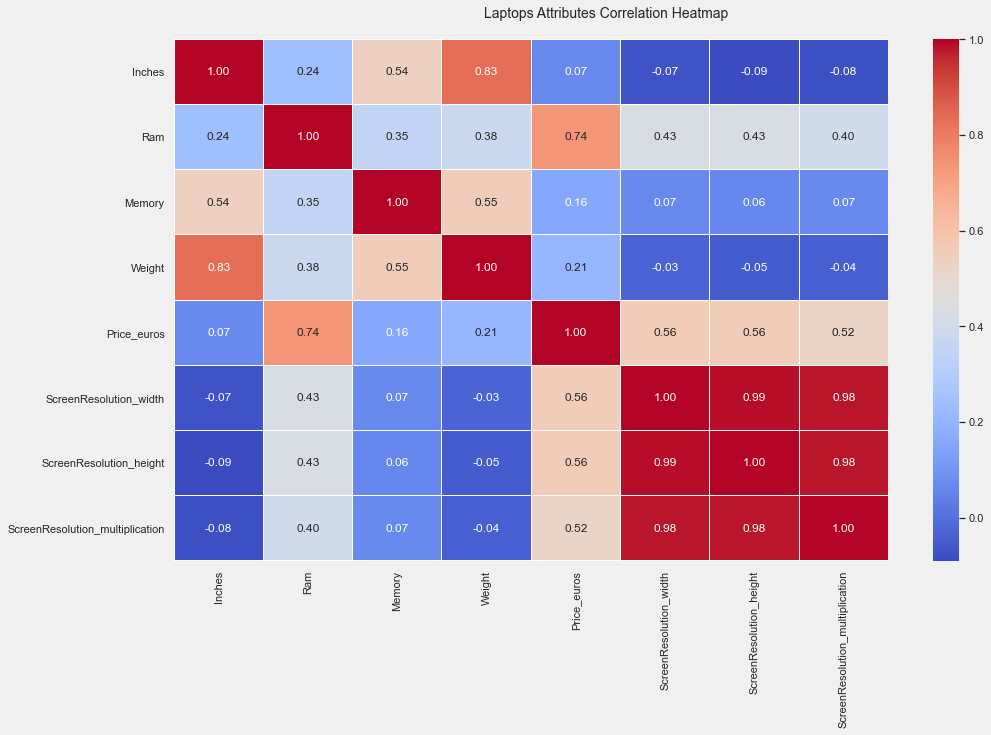

In [23]:
f, ax = plt.subplots(figsize = (10, 6))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot = True, ax = ax, cmap = "coolwarm", fmt = '.2f', linewidths = .05)
f.subplots_adjust(top = .93)
t= f.suptitle('Laptops Attributes Correlation Heatmap', fontsize = 14)
plt.gcf().set_size_inches(16, 9)

Изначально я ошибся, мультиколлинеарность все же есть. Из 3 переменных - ширина, высота, и одно, помноженное на другое, нужно оставить лишь одну. Ширина и высота одинаково коррелируют с таргетом (причем достаточно неплохо), поэтому можно оставить одну из них - и неважно, какую (пусть будет ширина). Помимо этого, у нас вес коррелирует с размером ноутбука, а с ценой лучше коррелирует вес. Я не вижу особого смысла в понижении размерности, или использовании каких-либо других хитрых методов преодоления проблемы мультиколлинеарности. Не то чтобы у нас слишком много признаков, чтобы их было сложно отсмотреть вручную, и не то чтобы там какие-то очень сложные и непонятные связи. Поэтому самым оптимальным вариантом кажется просто выкинуть лишнее

In [24]:
df = df.drop(['ScreenResolution_height', 'ScreenResolution_multiplication', 'Inches'], axis=1)
df.shape

(1302, 10)

### 2.2 Checkpoint

Итого мы имеем дело с пространственными данными по ноутбукам. У нас 1302 наблюдения, и 9 более менее адекватных, обработанных, не коррелирующих друг с другом признаков. 5 из этих признаков - категориальные

### 2.3 Выбросы по численным признакам и таргету

Хоть у нас и немного наблюдений, выбросы могут быть очень большой проблемой. Поэтому надо проверить их наличие (хотя они есть всегда), и подумать, что с ними можно сделать

##### 2.3.1 Таргет

Посмотрим на его распределение

In [25]:
df['Price_euros'].describe([.01, .05, .1, .25, .5, .75, .9, .95, .99])

count    1302.000000
mean     1124.205184
std       699.027220
min       174.000000
1%        229.000000
5%        309.000000
10%       393.531000
25%       599.000000
50%       978.000000
75%      1488.435000
90%      2040.900000
95%      2448.800000
99%      3148.983700
max      6099.000000
Name: Price_euros, dtype: float64

In [26]:
a = pd.DataFrame(df.Company.value_counts().reset_index())
a.columns = ['Brand', 'Count_a']
a.head()

,Brand,Count_a
0,Dell,297
1,Lenovo,297
2,HP,274
3,Asus,158
4,Acer,103


Максимальное значение - точно выброс, минимальное - пока непонятно. Предлагаю посмотреть, сколько ноутбуков стоят менее 300 евро, и сколько ноутбуков стоят более 2.5к

In [27]:
df_check = df.loc[(df['Price_euros'] < 300) | (df['Price_euros'] > 2500)]
df_check

,Company,TypeName,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenResolution_width
3,Apple,Ultrabook,Intel Core i7,16.0,512.0,AMD,macOS,1.83,2537.45,2880.0
17,Apple,Ultrabook,Intel Core i7,16.0,512.0,AMD,macOS,1.83,2858.00,2880.0
20,Asus,Netbook,Intel Other,2.0,32.0,Intel Graphics,Windows 10,0.98,191.90,1366.0
22,HP,Notebook,AMD,4.0,500.0,AMD,No OS,1.86,258.00,1366.0
30,Chuwi,Notebook,Intel Other,4.0,64.0,Intel Graphics,Windows 10,1.89,244.99,1920.0
...,...,...,...,...,...,...,...,...,...,...
1281,HP,Netbook,Intel Other,2.0,32.0,Intel Graphics,Windows 10,1.17,209.00,1366.0
1285,Lenovo,Notebook,Intel Other,2.0,64.0,Intel Graphics,Windows 10,1.50,229.00,1366.0
1290,Acer,Notebook,Intel Other,4.0,500.0,Intel Graphics,Linux,2.40,289.00,1366.0
1295,HP,Netbook,Intel Other,2.0,32.0,Intel Graphics,Windows 10,1.17,209.00,1366.0


In [28]:
115 / 1302

0.08832565284178187

Просто избавляться от 9% данных не хочется, но хочется кое-что проверить

Хочу протестировать одну гипотезу. Может быть, есть специальные бренды ноутбуков, которые производят очень дешевые, или, наоборот, очень дорогие товары. В таком случае, их выкидывать не стоит, так как дамми переменная их бренда позволит понять, сколько они примерно стоят, но при этом у нас будет больше наблюдений для создания хорошей крепкой модели. Для этого мы посмотрим, сколько товаров каких брендов мы распознали как потенциально выбросные, и сколько товаров каких брендов было изначально

In [29]:
b = pd.DataFrame(df_check.Company.value_counts().reset_index())
b.columns = ['Brand', 'Count_b']
b.head()

,Brand,Count_b
0,Lenovo,25
1,Dell,22
2,Asus,17
3,HP,16
4,Acer,11


In [30]:
exp = a.merge(b, on='Brand', how='inner')
exp['ratio'] = exp['Count_b'] / exp['Count_a']
exp.head()

,Brand,Count_a,Count_b,ratio
0,Dell,297,22,0.074074
1,Lenovo,297,25,0.084175
2,HP,274,16,0.058394
3,Asus,158,17,0.107595
4,Acer,103,11,0.106796


In [31]:
exp_1 = exp.loc[exp['ratio'] > 0.5]
exp_1

,Brand,Count_a,Count_b,ratio
9,Mediacom,7,5,0.714286
10,Razer,7,5,0.714286
12,Vero,4,4,1.000000
13,Chuwi,2,2,1.000000


Мне не очень интересно, эти бренды очень дорогие, или очень дешевые. При этом я бы от них не избавлялся, так как их в общем и целом можно посчитать выбросными (то есть значение признака бренд позволяет модели понять, что это выброс, и что его нужно прогнозировать по-другому)

In [32]:
good_brands = exp_1['Brand'].tolist()
good_brands

['Mediacom', 'Razer', 'Vero', 'Chuwi']

In [33]:
all_brands = list(set(df['Company'].tolist()))

bad_brands = list(set(all_brands) - set(good_brands))

bad_brands

['Huawei',
 'LG',
 'Fujitsu',
 'Dell',
 'Xiaomi',
 'Samsung',
 'Google',
 'Microsoft',
 'Asus',
 'Apple',
 'Acer',
 'MSI',
 'Toshiba',
 'Lenovo',
 'HP']

In [34]:
df

,Company,TypeName,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenResolution_width
0,Apple,Ultrabook,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.37,1339.69,2560.0
1,Apple,Ultrabook,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.34,898.94,1440.0
2,HP,Notebook,Intel Core i5,8.0,256.0,Intel Graphics,No OS,1.86,575.00,1920.0
3,Apple,Ultrabook,Intel Core i7,16.0,512.0,AMD,macOS,1.83,2537.45,2880.0
4,Apple,Ultrabook,Intel Core i5,8.0,256.0,Intel Graphics,macOS,1.37,1803.60,2560.0
...,...,...,...,...,...,...,...,...,...,...
1297,Lenovo,2 in 1 Convertible,Intel Core i7,4.0,128.0,Intel Graphics,Windows 10,1.80,638.00,1920.0
1298,Lenovo,2 in 1 Convertible,Intel Core i7,16.0,512.0,Intel Graphics,Windows 10,1.30,1499.00,3200.0
1299,Lenovo,Notebook,Intel Other,2.0,64.0,Intel Graphics,Windows 10,1.50,229.00,1366.0
1300,HP,Notebook,Intel Core i7,6.0,1024.0,AMD,Windows 10,2.19,764.00,1366.0


In [35]:
bad_rows = df.loc[(df['Company'].isin(bad_brands)) & ((df['Price_euros'] < 300) | (df['Price_euros'] > 2500))]
bad_rows

,Company,TypeName,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenResolution_width
3,Apple,Ultrabook,Intel Core i7,16.0,512.0,AMD,macOS,1.83,2537.45,2880.0
17,Apple,Ultrabook,Intel Core i7,16.0,512.0,AMD,macOS,1.83,2858.00,2880.0
20,Asus,Netbook,Intel Other,2.0,32.0,Intel Graphics,Windows 10,0.98,191.90,1366.0
22,HP,Notebook,AMD,4.0,500.0,AMD,No OS,1.86,258.00,1366.0
31,Asus,Notebook,AMD,2.0,32.0,AMD,Windows 10,1.65,199.00,1366.0
...,...,...,...,...,...,...,...,...,...,...
1281,HP,Netbook,Intel Other,2.0,32.0,Intel Graphics,Windows 10,1.17,209.00,1366.0
1285,Lenovo,Notebook,Intel Other,2.0,64.0,Intel Graphics,Windows 10,1.50,229.00,1366.0
1290,Acer,Notebook,Intel Other,4.0,500.0,Intel Graphics,Linux,2.40,289.00,1366.0
1295,HP,Netbook,Intel Other,2.0,32.0,Intel Graphics,Windows 10,1.17,209.00,1366.0


In [36]:
indices = bad_rows.index
indices

Int64Index([   3,   17,   20,   22,   31,   35,   67,  125,  127,  136,  177,
             190,  204,  238,  247,  290,  297,  314,  325,  329,  338,  340,
             346,  378,  389,  398,  399,  423,  429,  448,  490,  502,  503,
             514,  516,  529,  551,  554,  562,  576,  577,  583,  609,  636,
             644,  649,  658,  684,  692,  694,  712,  716,  722,  743,  748,
             757,  768,  779,  795,  817,  834,  840,  849,  856,  887,  893,
             910,  931,  938,  954,  967,  971,  991, 1016, 1048, 1049, 1065,
            1080, 1101, 1102, 1115, 1131, 1135, 1150, 1167, 1188, 1197, 1202,
            1206, 1214, 1262, 1267, 1271, 1276, 1281, 1285, 1290, 1295, 1299],
           dtype='int64')

In [37]:
df_new = df.drop(indices, axis=0)
df_new.index = np.arange(0, len(df_new))

In [38]:
df_new

,Company,TypeName,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenResolution_width
0,Apple,Ultrabook,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.37,1339.69,2560.0
1,Apple,Ultrabook,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.34,898.94,1440.0
2,HP,Notebook,Intel Core i5,8.0,256.0,Intel Graphics,No OS,1.86,575.00,1920.0
3,Apple,Ultrabook,Intel Core i5,8.0,256.0,Intel Graphics,macOS,1.37,1803.60,2560.0
4,Acer,Notebook,AMD,4.0,500.0,AMD,Windows 10,2.10,400.00,1366.0
...,...,...,...,...,...,...,...,...,...,...
1198,Asus,Notebook,Intel Core i7,4.0,500.0,Nvidia GeForce,Windows 10,2.20,720.32,1366.0
1199,Lenovo,2 in 1 Convertible,Intel Core i7,4.0,128.0,Intel Graphics,Windows 10,1.80,638.00,1920.0
1200,Lenovo,2 in 1 Convertible,Intel Core i7,16.0,512.0,Intel Graphics,Windows 10,1.30,1499.00,3200.0
1201,HP,Notebook,Intel Core i7,6.0,1024.0,AMD,Windows 10,2.19,764.00,1366.0


##### 2.3.2 Посмотрим на распределения признаков

In [39]:
df_new['Ram'].value_counts()

8.0     612
4.0     341
16.0    173
6.0      40
12.0     25
2.0       7
32.0      3
24.0      2
Name: Ram, dtype: int64

Явных выбросов я тут не вижу + я, скорее всего, закодирую этот признак как категориальный тоже, поэтому тут ничего трогать не будем

In [40]:
df_new['Memory'].describe([.01, .05, .1, .25, .5, .75, .9, .95, .99]) 

count    1203.000000
mean      620.066500
std       468.868567
min         8.000000
1%         32.000000
5%        128.000000
10%       180.000000
25%       256.000000
50%       500.000000
75%      1024.000000
90%      1148.000000
95%      1280.000000
99%      2160.000000
max      2560.000000
Name: Memory, dtype: float64

In [41]:
df_new['Memory'].value_counts()

256.0     411
1024.0    236
500.0     121
512.0     113
1148.0     92
128.0      79
1280.0     63
32.0       25
2048.0     17
64.0       10
2304.0     10
1536.0      7
180.0       5
16.0        4
2160.0      2
756.0       2
2560.0      2
768.0       1
508.0       1
1088.0      1
8.0         1
Name: Memory, dtype: int64

А тут уже будем что-то трогать. 2160 и более кажется много, а 16 и меньше кажется мало. Просто выкинем эти наблюдения. И мне не нравится новое название датафрейма, вернемся к старому

In [42]:
df = df_new.loc[(df_new['Memory'] < 2160) & (df_new['Memory'] > 16)]
df.index = np.arange(0, len(df))
df

,Company,TypeName,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenResolution_width
0,Apple,Ultrabook,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.37,1339.69,2560.0
1,Apple,Ultrabook,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.34,898.94,1440.0
2,HP,Notebook,Intel Core i5,8.0,256.0,Intel Graphics,No OS,1.86,575.00,1920.0
3,Apple,Ultrabook,Intel Core i5,8.0,256.0,Intel Graphics,macOS,1.37,1803.60,2560.0
4,Acer,Notebook,AMD,4.0,500.0,AMD,Windows 10,2.10,400.00,1366.0
...,...,...,...,...,...,...,...,...,...,...
1179,Asus,Notebook,Intel Core i7,4.0,500.0,Nvidia GeForce,Windows 10,2.20,720.32,1366.0
1180,Lenovo,2 in 1 Convertible,Intel Core i7,4.0,128.0,Intel Graphics,Windows 10,1.80,638.00,1920.0
1181,Lenovo,2 in 1 Convertible,Intel Core i7,16.0,512.0,Intel Graphics,Windows 10,1.30,1499.00,3200.0
1182,HP,Notebook,Intel Core i7,6.0,1024.0,AMD,Windows 10,2.19,764.00,1366.0


In [43]:
df['Weight'].describe([.01, .05, .1, .25, .5, .75, .9, .95, .99]) # тут вроде все окей

count    1184.000000
mean        2.008184
std         0.593733
min         0.690000
1%          0.920000
5%          1.200000
10%         1.260000
25%         1.540000
50%         2.040000
75%         2.300000
90%         2.700000
95%         2.982500
99%         4.140000
max         4.600000
Name: Weight, dtype: float64

In [44]:
df['ScreenResolution_width'].describe([.01, .05, .1, .25, .5, .75, .9, .95, .99]) # тут вроде все окей тоже

count    1184.000000
mean     1885.951014
std       453.805155
min      1366.000000
1%       1366.000000
5%       1366.000000
10%      1366.000000
25%      1920.000000
50%      1920.000000
75%      1920.000000
90%      1920.000000
95%      2560.000000
99%      3840.000000
max      3840.000000
Name: ScreenResolution_width, dtype: float64

Категориальные признаки мы уже обработали, поэтому можно считать, что обработка данных полностью завершена. Можно, наконец-то, переходить к чему-то интересному

# 3 Анализ признаков & визуализация

In [45]:
df.head()

,Company,TypeName,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenResolution_width
0,Apple,Ultrabook,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.37,1339.69,2560.0
1,Apple,Ultrabook,Intel Core i5,8.0,128.0,Intel Graphics,macOS,1.34,898.94,1440.0
2,HP,Notebook,Intel Core i5,8.0,256.0,Intel Graphics,No OS,1.86,575.00,1920.0
3,Apple,Ultrabook,Intel Core i5,8.0,256.0,Intel Graphics,macOS,1.37,1803.60,2560.0
4,Acer,Notebook,AMD,4.0,500.0,AMD,Windows 10,2.10,400.00,1366.0


### 3.1 Посмотрим, как часто встречаются те или иные категориальные признаки

Будем использовать облака слов. Мне это кажется более удобным, когда речь идет конкретно про слова, нежели построение столбчатых диаграм. Я не ставлю цели узнать конкретные числа, мне важнее просто примерно понять, что и как тут устроено

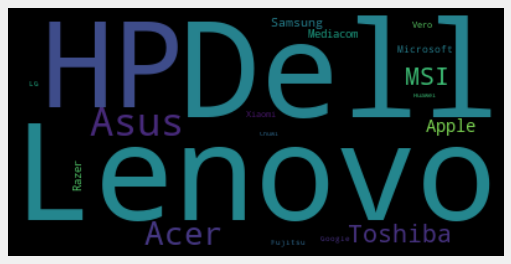

In [46]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = ' '.join(df.Company.values.tolist())
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

То есть какие-то бренды встречаются прям очень часто, а какие-то встречаются крайне редко. Тут я тоже воспользовался готовым скриптом, но уже от другого человека, который анализировал +- аналогичный, но другой датасет (https://www.kaggle.com/code/dhanush232/laptop-price-prediction). Он же построил множество других неплохих графиков, а также построил много ML-моделей для решения задачи предсказания (при этом я этим анализом не пользовался)

Сделаем такую же процедуру для других категориальных признаков. Не вижу особого смысла это интерпретировать, но, если вдруг будет интересно, с чем мы вообще работаем - может быть, стоит на это посмотреть

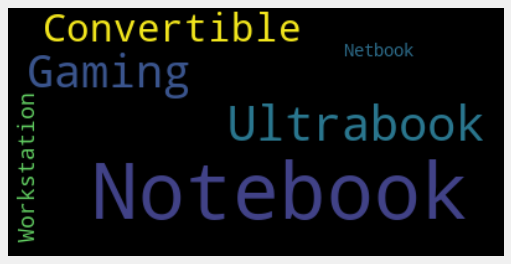

In [47]:
figure(figsize=(8, 6), dpi=80)
text = ' '.join(df.TypeName.values.tolist())
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

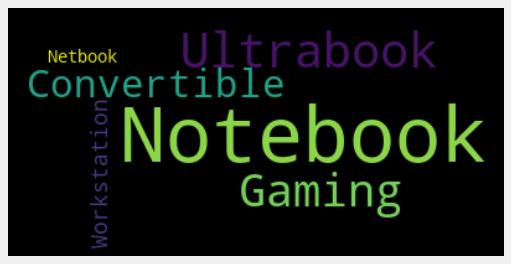

In [48]:
figure(figsize=(8, 6), dpi=80)
text = ' '.join(df.TypeName.values.tolist())
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

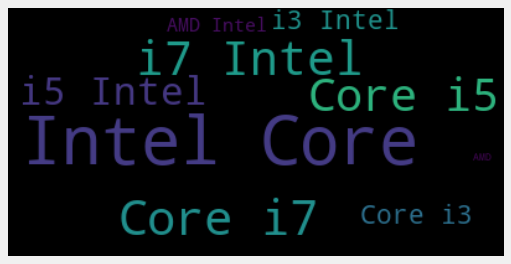

In [49]:
figure(figsize=(8, 6), dpi=80)
text = ' '.join(df.Cpu.values.tolist())
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

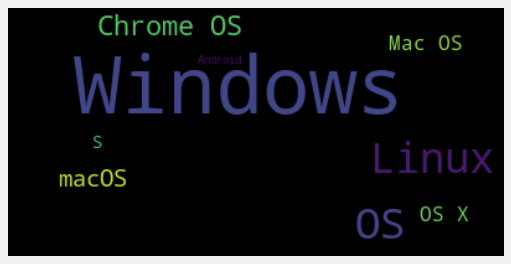

In [50]:
figure(figsize=(8, 6), dpi=80)
text = ' '.join(df.OpSys.values.tolist())
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Ой, кажется я забыл обработать этот признак. macOS и Mac OS - явно одно и то же. У нас есть готовый код, который поможет разобраться с этим. Помимо этого, сразу начнем уже заниматься нормальным анализом и проверим, ноутбуки каких операционных систем стоят дороже, а каких - дешевле

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


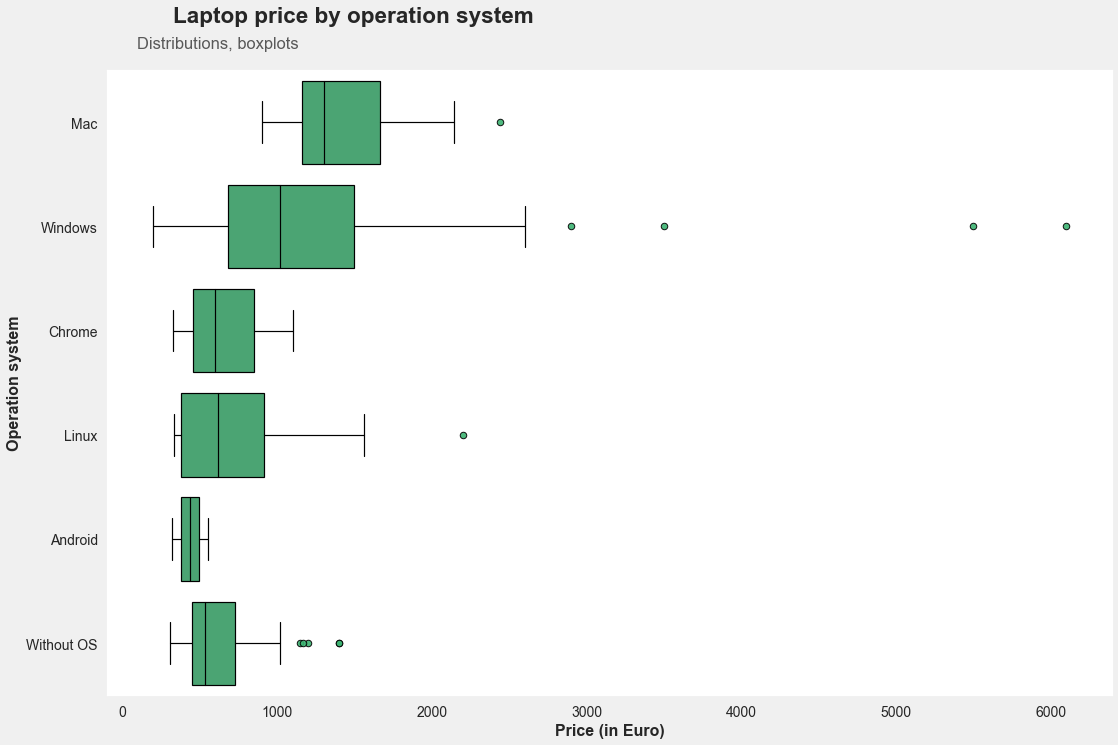

In [51]:
df['OpSys'] = np.select(
       [df['OpSys'].isin(["macOS", "Mac OS X"]), 
        df['OpSys'].isin(["Windows 10", "Windows 7", 'Windows 10 S']),
        df['OpSys'].isin(["Chrome OS"]),
        df['OpSys'].isin(["Linux"]),
        df['OpSys'].isin(["Android"]),
        df['OpSys'].isin(["No OS"])], 
        ['Mac', 'Windows', 'Linux', 'Chrome', 'Android', 'Without OS'], 
    default = 'Unknown')

plot_box(x = "Price_euros", y = "OpSys", xlabel = 'Price (in Euro)', ylabel = "Operation system", title = "Laptop price by operation system",
         subtitle = "Distributions, boxplots", color = "mediumseagreen", order = ['Mac', 'Windows', 'Chrome', 'Linux', 'Android', 'Without OS'],
         title_position = 0.245, subtitle_position = 0.11)

In [52]:
df['OpSys'].value_counts()

Windows       1035
Without OS      60
Chrome          53
Mac             19
Linux           15
Android          2
Name: OpSys, dtype: int64

Что Маки, в среднем, дороже Винды - это понятно и так, но тут можно найти интересные наблюдения. Почти на всех ОС есть выбросы, причем всегда в большую сторону. При этом не обязательно разброс связан с бОльшим количеством ноутбуков (например, у Mac диапазон шире, чем у Chrome, хотя их почти в 3 раза меньше). То есть как минимум с некоторыми ОС достаточно просто предсказать цену на ноутбук, так как они лежат в +- фиксированном диапазоне

### 3.2 Перейдем к более серьезному анализу

Хочу проверить графически, насколько связь между оперативкой и ценой может быть описана как линейная

Text(0.5, 1.0, 'Relationship between RAM and Price')

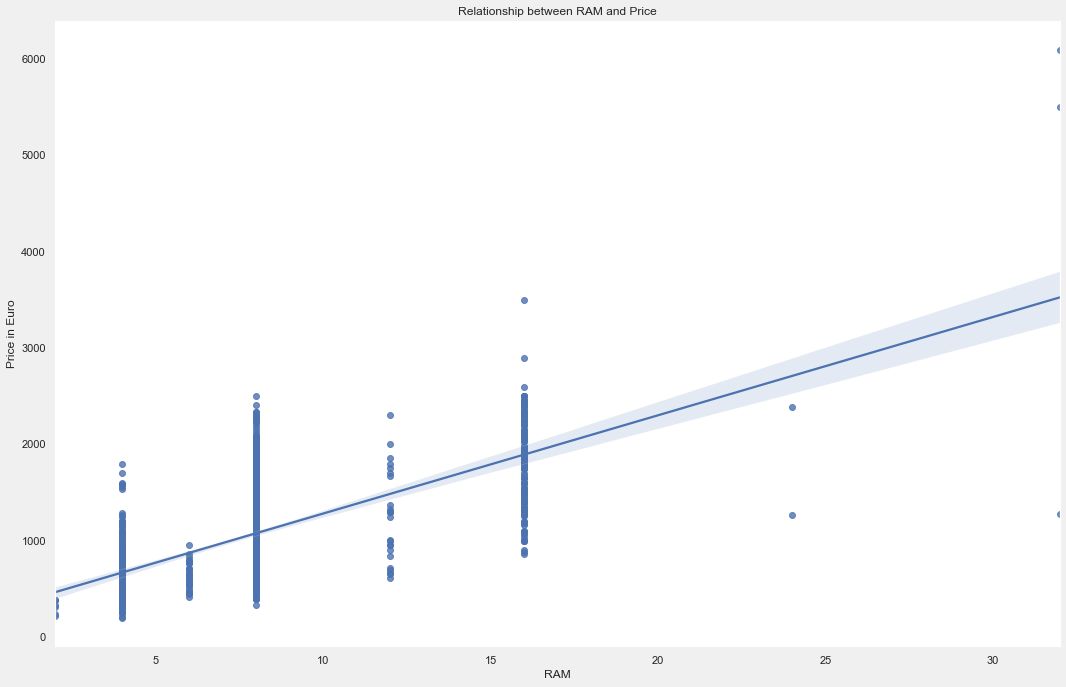

In [53]:
import seaborn as sns
sns.regplot(df['Ram'], df['Price_euros'])
plt.xlabel('RAM')
plt.ylabel('Price in Euro')
plt.title('Relationship between RAM and Price')

Ну примерно понятно, но не особо. Сделаем слегка нагляднее - возьмем случайную подвыборку и переведем данные к более непрерывному виду, добавив случайный шум

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0.5, 1.0, 'Relationship between RAM and Price')

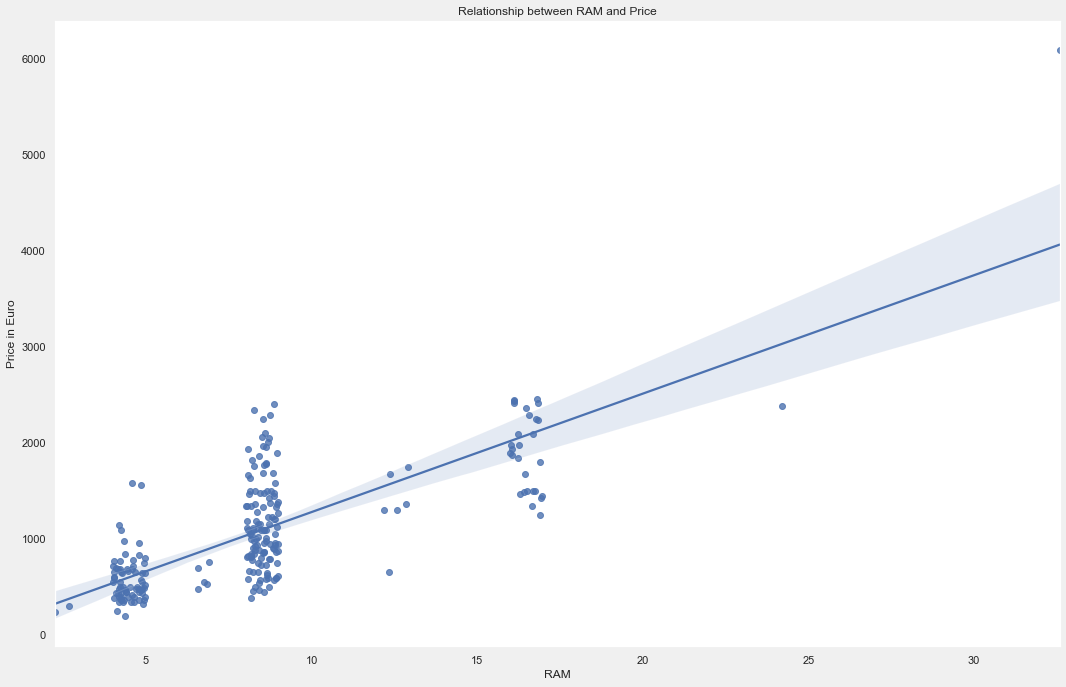

In [54]:
import random
tmp = df.sample(frac=0.2)
tmp.index = np.arange(0, len(tmp))
for i in range(len(tmp)):
    tmp['Ram'][i] = tmp['Ram'][i] + random.random()
    
#plt.scatter(tmp['Ram'], tmp['Price_euros'])
sns.regplot(tmp['Ram'], tmp['Price_euros'])
plt.xlabel('RAM')
plt.ylabel('Price in Euro')
plt.title('Relationship between RAM and Price')

Связь может быть описана как линейная, но явно одной оперативкой цену не спрогнозируешь. Быстро посмотрим на аналогичные графики для других признаков, а потом попробуем посмотреть на связь нескольких признаков с ценой

Text(0.5, 1.0, 'Relationship between Memory and Price')

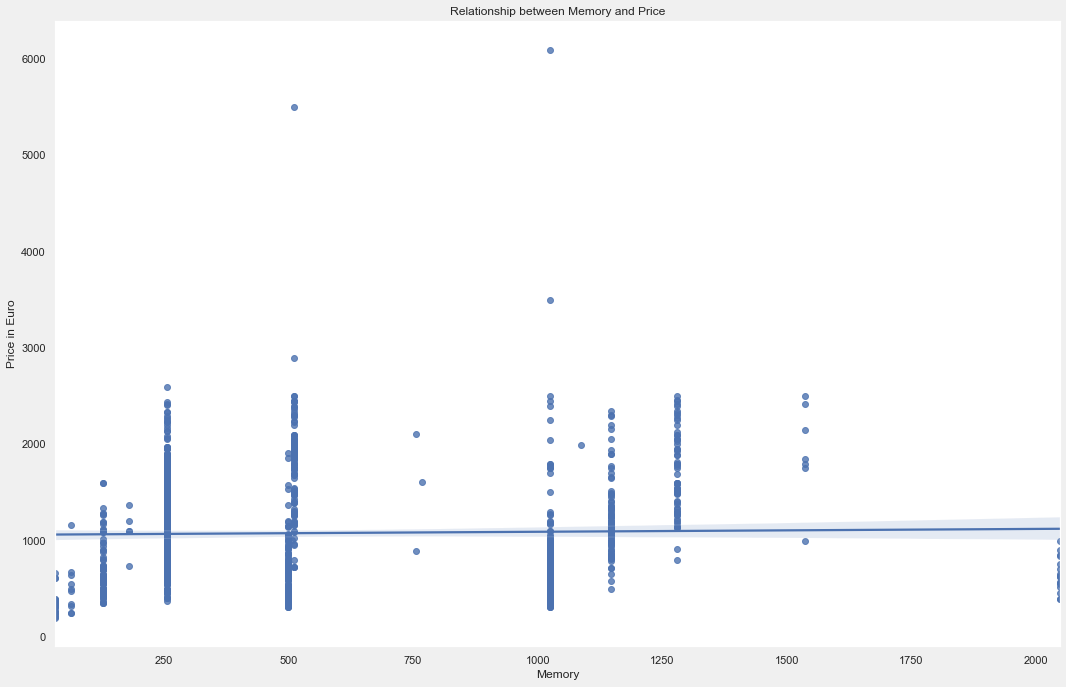

In [55]:
sns.regplot(df['Memory'], df['Price_euros'])
plt.xlabel('Memory')
plt.ylabel('Price in Euro')
plt.title('Relationship between Memory and Price')

Text(0.5, 1.0, 'Relationship between Weight and Price')

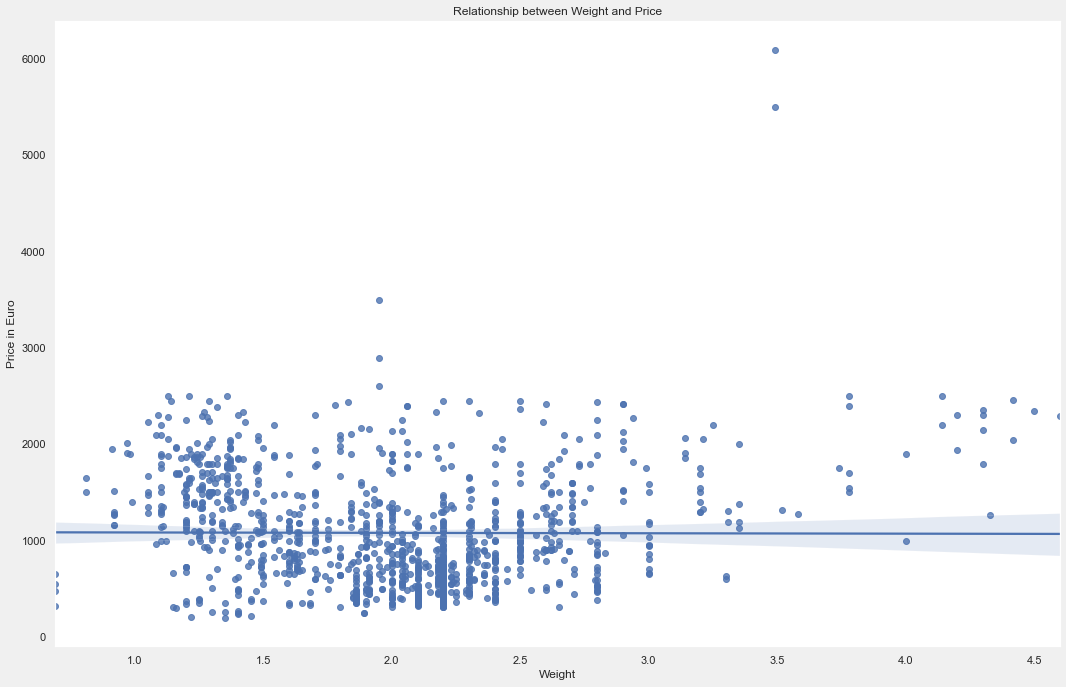

In [56]:
sns.regplot(df['Weight'], df['Price_euros'])
plt.xlabel('Weight')
plt.ylabel('Price in Euro')
plt.title('Relationship between Weight and Price')

Text(0.5, 1.0, 'Relationship between ScreenResolution_width and Price')

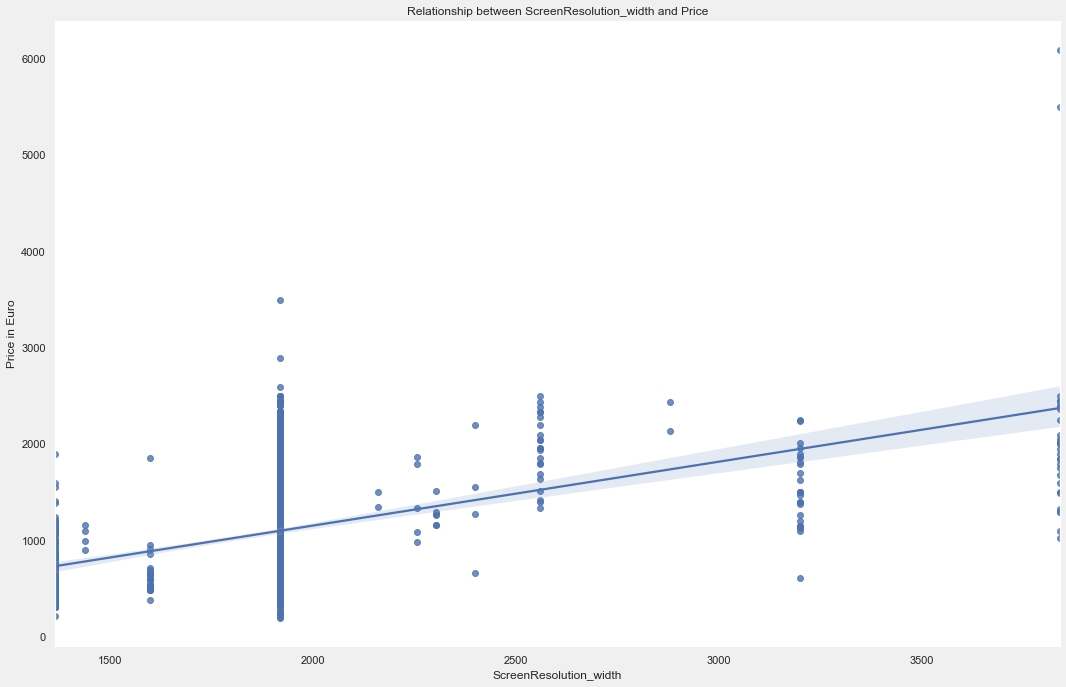

In [57]:
sns.regplot(df['ScreenResolution_width'], df['Price_euros'])
plt.xlabel('ScreenResolution_width')
plt.ylabel('Price in Euro')
plt.title('Relationship between ScreenResolution_width and Price')

Кажется, что вес и размер хранилища ноутбука особо не влияют на цену (линии прям очень близко к горизонтальным). В случае, с хранилищем, это кажется странным. Ключевую роль, я думаю, всегда играют бренды и процессоры, но неужели это не коррелирует с размеру памяти на ноутбуке? Предлагаю проверить

In [58]:
for_plotting = df.groupby('Company')['Price_euros', 'Memory'].agg('mean').reset_index().sort_values('Price_euros', ascending=False)
for_plotting

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Company,Price_euros,Memory
14,Razer,3346.142857,585.142857
9,LG,2099.000000,512.000000
6,Google,1677.666667,298.666667
11,MSI,1629.052917,1129.166667
15,Samsung,1556.500000,339.500000
1,Apple,1444.880000,303.157895
8,Huawei,1424.000000,384.000000
13,Microsoft,1416.970000,204.800000
16,Toshiba,1235.234043,316.340426
18,Xiaomi,1133.462500,256.000000


Text(0.5, 1.0, 'Testing a hypothesis')

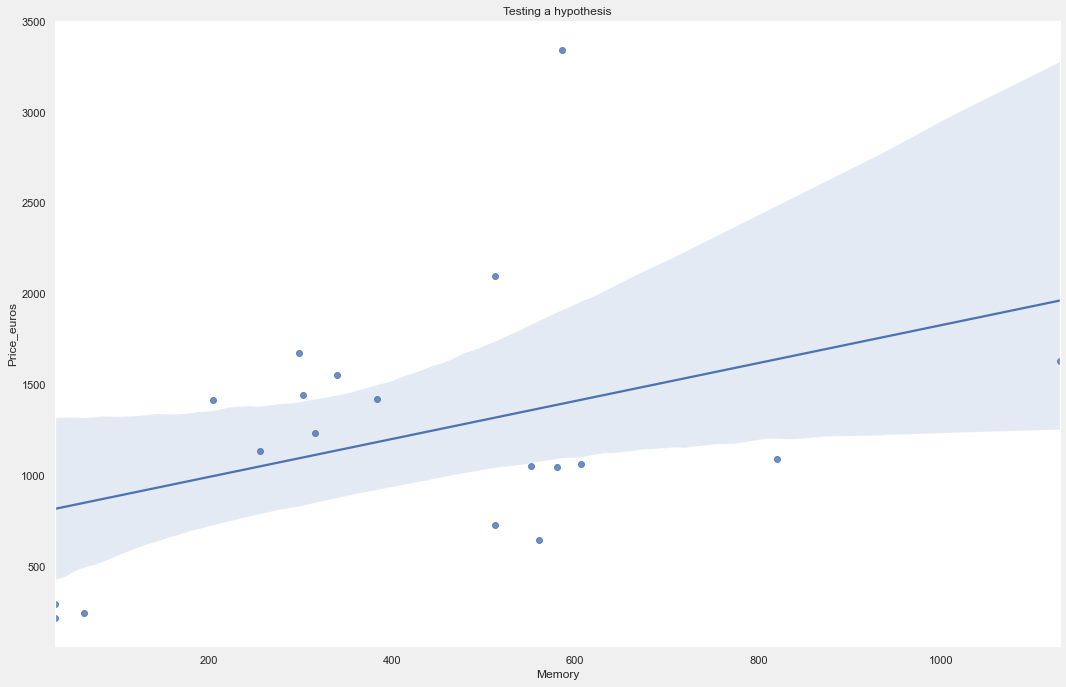

In [59]:
sns.regplot(for_plotting['Memory'], for_plotting['Price_euros'])
plt.xlabel('Memory')
plt.ylabel('Price_euros')
plt.title('Testing a hypothesis')

In [60]:
for_plotting = df.groupby('Cpu')['Price_euros', 'Memory'].agg('mean').reset_index().sort_values('Price_euros', ascending=False)
for_plotting

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Cpu,Price_euros,Memory
3,Intel Core i7,1468.047704,706.309013
2,Intel Core i5,1015.015248,502.411348
5,Other,659.000000,32.000000
0,AMD,591.618214,775.071429
4,Intel Other,550.822549,411.137255
1,Intel Core i3,541.625956,634.970588


Text(0.5, 1.0, 'Testing a hypothesis')

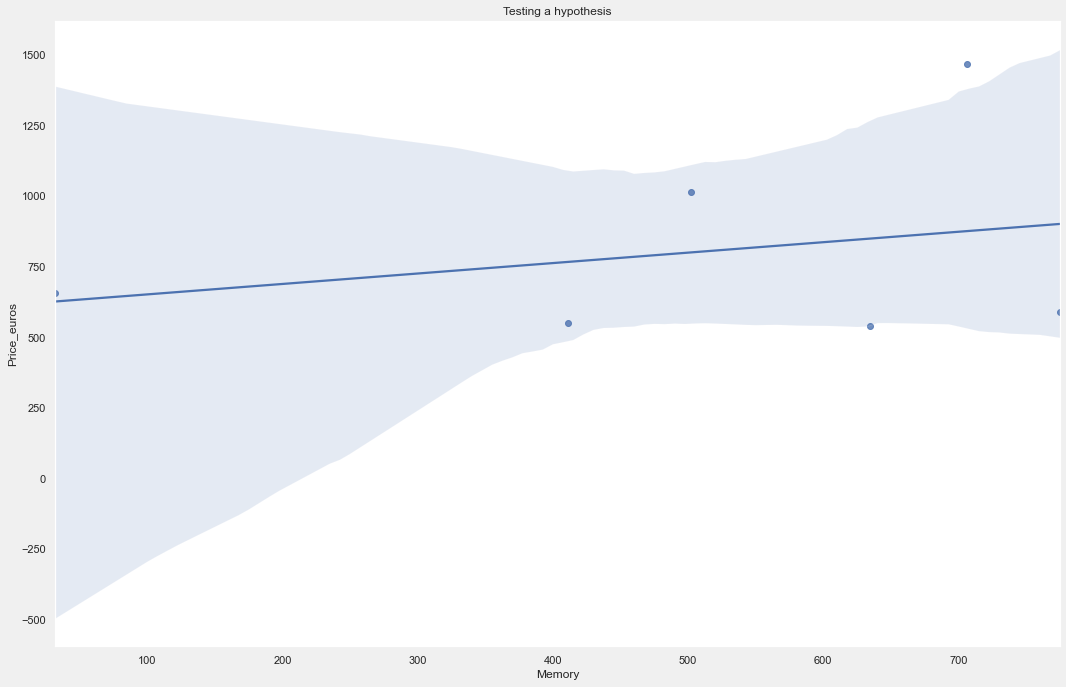

In [61]:
sns.regplot(for_plotting['Memory'], for_plotting['Price_euros'])
plt.xlabel('Memory')
plt.ylabel('Price_euros')
plt.title('Testing a hypothesis')

Объясню, что я сделал. У меня возникла гипотеза, что ноутбуки, которые производят более дорогие (с точки зрения средней цены) компании, имеют большую память. Если она отвергнется, то в принципе понятно, почему нет линейной связи между памятью и ценой на ноутбук. Соответственно для каждой компании и для каждого процессора я взял среднюю память и среднюю цену на ноутбук, отсортировал это, и построил график. В принципе, связь вроде как чуть-чуть линейна, но при этом у нас очень большая дисперсия, и в принципе никакой сильной зависимости нет. Поэтому действительно скорее важнее процессор и бренд, а признак памяти можно выкинуть. Признак веса мне не казался важным и до этого, поэтому его тоже можно выкинуть. При этом я хочу статистически проверить гипотезу о том, что эти признаки не важны. Для этого сохраню файл в таком виде перед тем, как выкидывать признаки. Впоследствии оценим модель на обоих датасетах

In [62]:
df.to_csv('prepocessed_laptops_for_model_more_features.csv')

In [63]:
df = df.drop(['Memory', 'Weight'], axis=1)

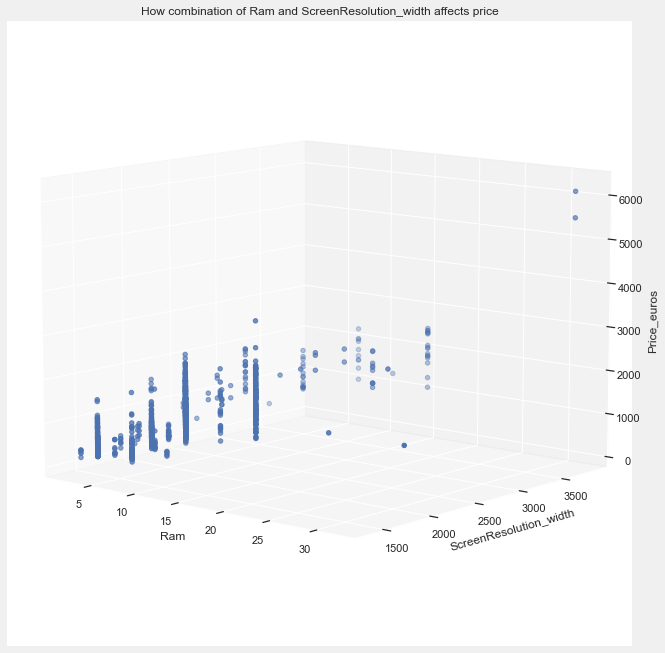

In [64]:
# https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure().gca(projection='3d')
threedee.scatter(df['Ram'], df['ScreenResolution_width'], df['Price_euros'])
threedee.set_xlabel('Ram')
threedee.set_ylabel('ScreenResolution_width')
threedee.set_zlabel('Price_euros')
threedee.view_init(elev=10., azim=-50)
plt.title('How combination of Ram and ScreenResolution_width affects price')
plt.show()

В среднем, чем вправее и вдаль мы движеся, тем выше цена. Значит эти признаки что-то о ней говорят, и хорошая идея их использовать

# Теперь можем утверждать, что наш датасет готов для построения модели

При этом мы уже много накодили, поэтому я предпочту сохранить файл csv в том виде, в котором он есть, а модели уже строить в другом блокноте

In [65]:
df.to_csv('prepocessed_laptops_for_model.csv')

# Источники

1) https://www.kaggle.com/datasets/muhammetvarl/laptop-price?datasetId=957775&language=Python - датасет, с которым мы работали

2) https://www.kaggle.com/code/michau96/what-determines-price-of-a-laptop - готовый код по работе с датасетом, который мы использовали для костыльной обработки данных и различных красивых визуализаций

3) https://www.kaggle.com/code/dhanush232/laptop-price-prediction - про облака текстов (также тут можно найти интересные инсайты для анализа похожих задач, но я их не использовал)

4) https://pythonprogramming.net/3d-graphing-pandas-matplotlib/ - 3D визуализация

# Прикольные картинки

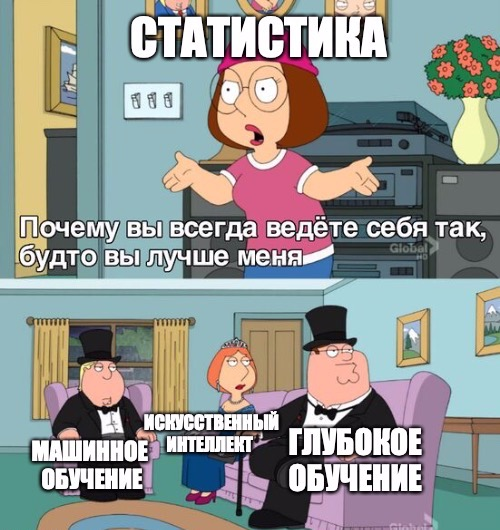

In [66]:
from IPython.display import Image
Image("IMG_7758.JPG")

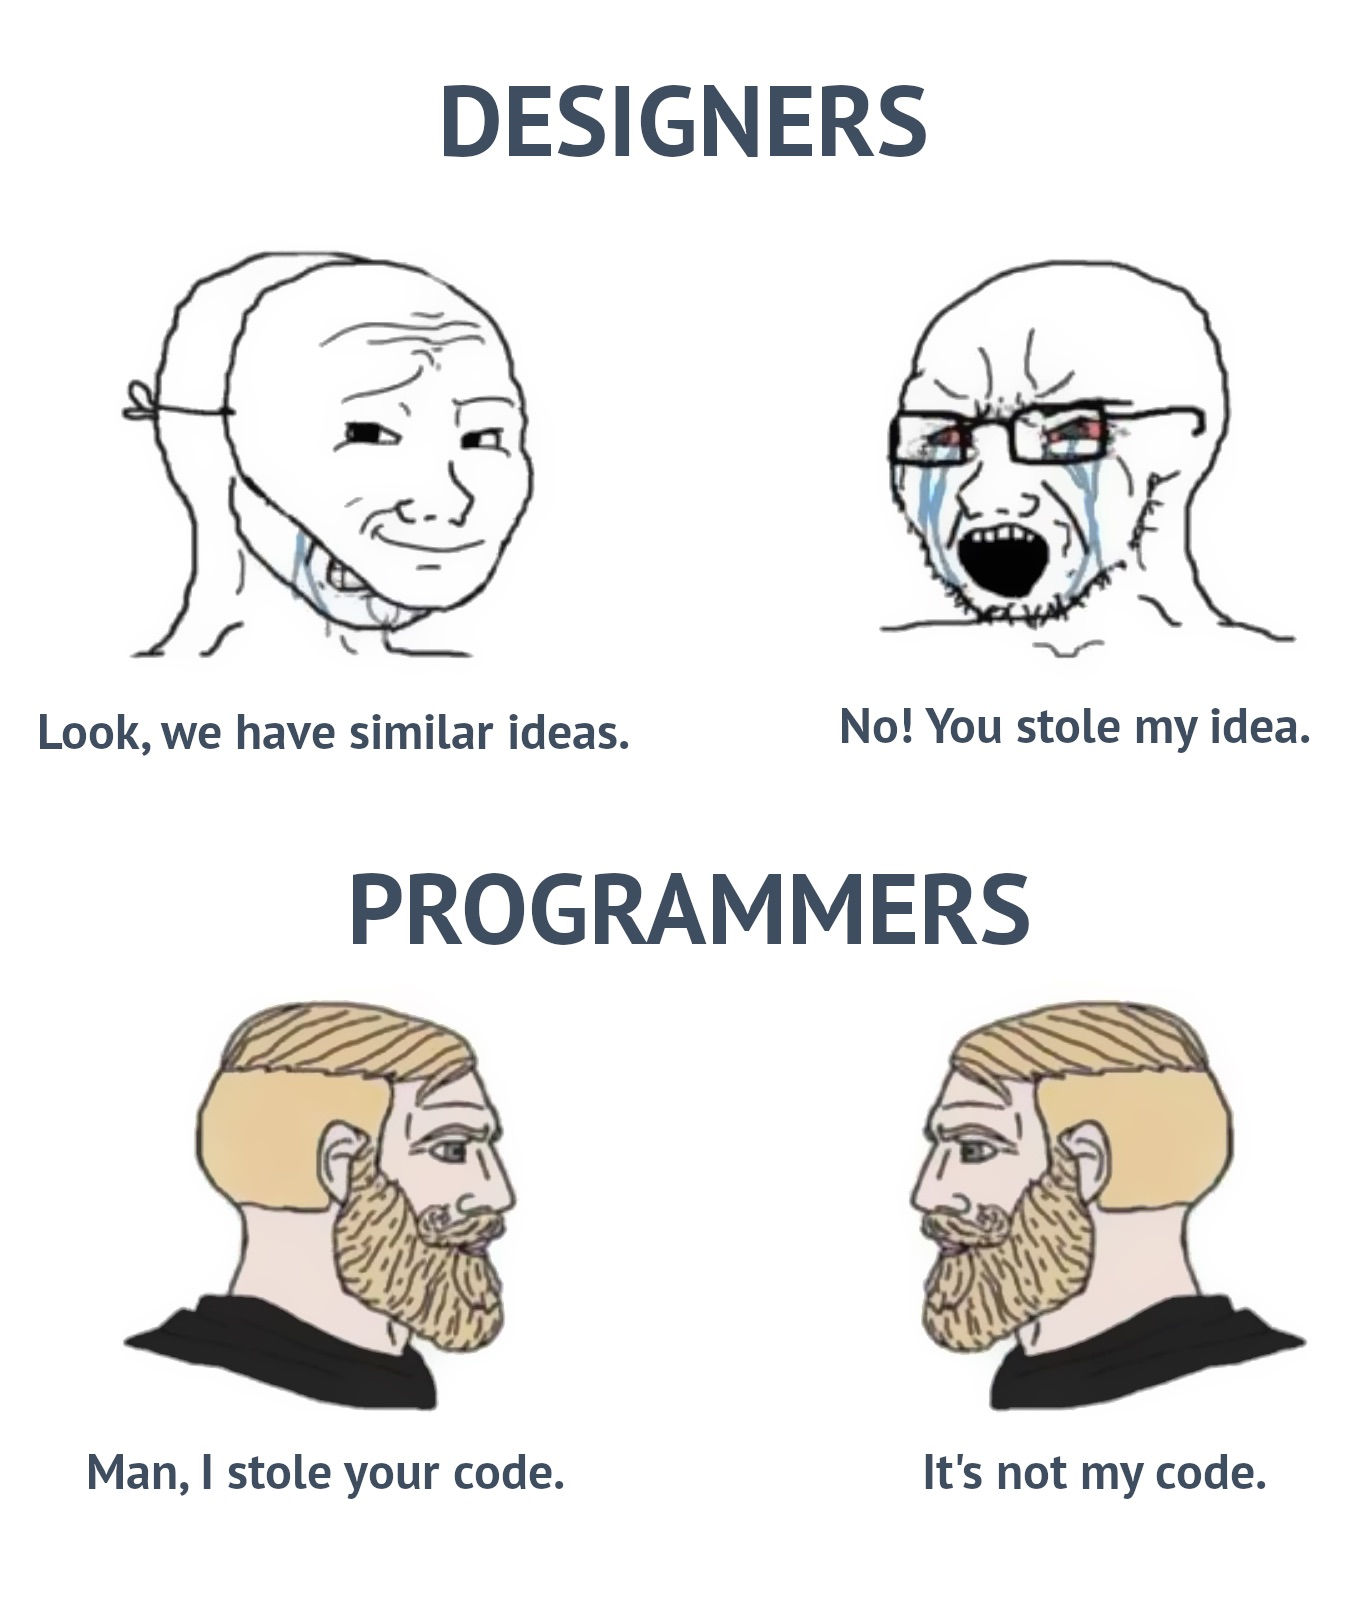

In [67]:
Image("IMG_7908.jpg")